# 2000 year reconstructions: Brennan et al 2020 comparison

## Figure 3 & Table 1

July 2020  
Katie Brennan  

In [1]:
import sys
import numpy as np
import pickle
import xarray as xr 

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

In [2]:
plt.rcParams['figure.dpi']=500

In [3]:
 def load_bren2020_full(): 
    data_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/Brennan_etal_2020/data/'
    filename = 'Brennan_etal_2020_sie_recons.nc'

    import xarray as xr

    data_bren2020 = xr.open_dataset(data_dir+filename)
    
    return data_bren2020

def load_bren2020_data(mod_list,temp_list):
    """INPUTS:
       mod_list = list of strings, all caps (ex: ['MPI','CCSM4'])
       temp_list = list of temperature datasets (ex: ['HadCRUT4','Berkeley_Earth','GISTEMP'])
    """
    data_bren2020 = load_bren2020_full()
    sie_bren2020 = {}
    sie_97_5_bren2020 = {}
    sie_2_5_bren2020 = {}
    
    for m in mod_list: 
        for d in temp_list: 
            sie_name = 'sie_'+m+'_'+d
            bren2020_time = data_bren2020[sie_name][d+'_time'].values
            sie_bren2020[sie_name] = np.nanmean(np.reshape(data_bren2020[sie_name].values,(169,1000)),axis=1)
            sie_97_5_bren2020[sie_name+'_97_5'] = data_bren2020[sie_name+'_97_5'].values
            sie_2_5_bren2020[sie_name+'_2_5'] = data_bren2020[sie_name+'_2_5'].values
            
    return bren2020_time, sie_bren2020, sie_97_5_bren2020, sie_2_5_bren2020


def load_annual_satellite(): 
    """Loads annual satellite data and finds anomalies that start at 1979 and go 
       to ANOM_END. 
    """
    # Import satellite data Fetterer v3: 
    fet_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/Fetterer_v3/'
    #fet_file = 'Fetterer_data_v3_annual_1978_2017.npz'
    fet_file = 'Fetterer_data_v3_annual_78_17.npz'

    # Load annual data
    fet_loc = fet_directory + fet_file
    fet_data = np.load(fet_loc)

    fet_sie = fet_data['si_extent']
    fet_sia = fet_data['si_area']
    fet_time = fet_data['time']
    
    return fet_sia, fet_sie, fet_time

def find_anomalies(TIME, VAR, ANOM_START, ANOM_END, mean=False):
    """Finds anomalies between (and including) ANOM_START and ANOM_END. 
       inputs: 
       TIME = array of years (time) 
       VAR = variable to take anomalies of (time)
       ANOM_START = year anomaly period starts
       ANOM_END = year anomaly period ends (included) 
    """
   
    gt = np.where(TIME>=ANOM_START)
    lt = np.where(TIME<=ANOM_END)
    
    VAR_mean = np.nanmean(VAR[gt[0].min():lt[0].max()],axis=0)
    VAR_anom = VAR - VAR_mean
    
    if mean is True: 
        return VAR_anom, VAR_mean
    else: 
        return VAR_anom
    
def find_ce_corr(VAR, REF, REF_TIME, VAR_TIME, START_TIME, END_TIME, detrend=False):
    """Finds the correlation coefficient and coefficient of efficiency between 
       REF and VAR between START_TIME and END_TIME.
       inputs: 
           VAR = test data (1D in time)
           REF = reference data (1D in time) 
           REF_time = reference data time (1D time)
           VAR_TIME = test data time (1D years)
           START_TIME = comparison start year to be included (float)
           END_TIME = last year included in comparison (float)
       
    """
    yr_range_var = np.where((VAR_TIME>=START_TIME)&(VAR_TIME<END_TIME+1))
    yr_range_ref = np.where((REF_TIME>=START_TIME)&(REF_TIME<END_TIME+1))
    
    if detrend is False: 
        ref = REF[yr_range_ref[0]]
        var = VAR[yr_range_var[0]]
    else: 
        ref = spy.detrend(REF[yr_range_ref])
        var = spy.detrend(VAR[yr_range_var])
        
    ce = coefficient_efficiency(ref,var)
    corr = np.corrcoef(ref,var)[0,1]
    var_ref = np.var(ref)
    var_var = np.var(var)
    
    return ce, corr,var_ref,var_var

def coefficient_efficiency(ref,test,valid=None):
    """
    ***Copied from LMR_utils.py 04/08/20***
    Compute the coefficient of efficiency for a test time series, 
    with respect to a reference time series.

    Inputs:
    test:  test array
    ref:   reference array, of same size as test
    valid: fraction of valid data required to calculate the statistic 

    Note: Assumes that the first dimension in test and ref arrays is time!!!

    Outputs:
    CE: CE statistic calculated following Nash & Sutcliffe (1970)
    """

    # check array dimensions
    dims_test = test.shape
    dims_ref  = ref.shape
    #print('dims_test: ', dims_test, ' dims_ref: ', dims_ref)

    if len(dims_ref) == 3:   # 3D: time + 2D spatial
        dims = dims_ref[1:3]
    elif len(dims_ref) == 2: # 2D: time + 1D spatial
        dims = dims_ref[1:2]
    elif len(dims_ref) == 1: # 0D: time series
        dims = 1
    else:
        print('In coefficient_efficiency(): Problem with input array dimension! Exiting...')
        SystemExit(1)

    CE = np.zeros(dims)

    # error
    error = test - ref

    # CE
    numer = np.nansum(np.power(error,2),axis=0)
    denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
    CE    = 1. - np.divide(numer,denom)

    if valid:
        nbok  = np.sum(np.isfinite(ref),axis=0)
        nball = float(dims_ref[0])
        ratio = np.divide(nbok,nball)
        indok  = np.where(ratio >= valid)
        indbad = np.where(ratio < valid)
        dim_indbad = len(indbad)
        testlist = [indbad[k].size for k in range(dim_indbad)]
        if not all(v == 0 for v in testlist):
            if isinstance(dims,(tuple,list)):
                CE[indbad] = np.nan
            else:
                CE = np.nan

    return CE

def load_annual_satellite_anom(ANOM_END): 
    """Loads annual satellite data and finds anomalies that start at 1979 and go 
       to ANOM_END. 
    """
    # Import satellite data Fetterer v3: 
    fet_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/Fetterer_v3/'
    #fet_file = 'Fetterer_data_v3_annual_1978_2017.npz'
    fet_file = 'Fetterer_data_v3_annual_78_17.npz'

    # Load annual data
    fet_loc = fet_directory + fet_file
    fet_data = np.load(fet_loc)

    fet_sie = fet_data['si_extent'][1:]
    fet_sia = fet_data['si_area'][1:]
    fet_sia_adj = fet_data['si_area_adj']
    fet_time = fet_data['time'][1:]

    # Find anomalies: 

    # Calculate mean 
    fet_anom_cent_sia = np.nanmean(fet_sia[np.where(fet_time<=ANOM_END)],axis=0)
    fet_anom_cent_sia_adj = np.nanmean(fet_sia_adj[np.where(fet_time[1:]<=ANOM_END)],axis=0)
    fet_anom_cent_sie = np.nanmean(fet_sie[np.where(fet_time<=ANOM_END)],axis=0)

    # Find anomalies:  
    fet_sia_anom = fet_sia - fet_anom_cent_sia
    fet_sia_anom_adj = fet_sia_adj - fet_anom_cent_sia_adj
    fet_sie_anom = fet_sie - fet_anom_cent_sie
    
    return fet_sia_anom, fet_sia_anom_adj, fet_sie_anom, fet_time

def load_annual_walsh(version=None):
    """
    Loads annualized total Arctic extent and area from Walsh et al version 1 or 2. 
    
    INPUTS: 
    version: integer value indicating the value of Walsh data to load (takes values: 1,2,None)
    
    OUTPUTS: 
    walsh_sia: total arctic sea ice area (km^2)
    walsh_sie: total arctic sea ice extent (km^2)
    walsh_time: years of walsh data (years)
    """
    walsh_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/walsh_comparison/'
    
    if version is None: 
        vera = 2
        vere = 2
    elif version == 3: 
        vera = 2
        vere = 3
    else: 
        vera = version
        vere = version

    walsh_sie_file_an = 'Walsh_annual_sie_km2_v'+str(vere)+'.npz'
    walsh_sia_file_an = 'Walsh_annual_sia_km2_v'+str(vera)+'.npz'

    walsh_sie_data_an = np.load(walsh_directory + walsh_sie_file_an)
    walsh_sia_data_an = np.load(walsh_directory + walsh_sia_file_an)
    
    walsh_time = walsh_sie_data_an['years']
    
    if version ==2: 
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']/1e6
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total']/1e6
    elif version ==3:     
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']/1e6
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total_amn_first']/1e6
    else: 
        walsh_sia = walsh_sia_data_an['walsh_nh_annual_area_total']
        walsh_sie = walsh_sie_data_an['walsh_nh_annual_extent_total']
    
#     if ver == 1: 
#         walsh_time = np.arange(1850,2014,1)
#     else: 
#         walsh_time = np.arange(1850,2018,1)
    
    return walsh_sia, walsh_sie, walsh_time

## Load reconstructions: 

In [4]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'
recon_file_mpi = 'Brennan_and_Hakim_2021_MPI_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)
recon_data_mpi = xr.open_dataset(recon_dir+recon_file_mpi)

In [5]:
sie_ensmn_anom_ccsm4 = recon_data_ccsm4.si_extent_ensemble_mean_anomalies.values
sie_ccsm4_97_5_anom = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_ccsm4_2_5_anom = recon_data_ccsm4.si_extent_2_5_percentiles.values

sia_ensmn_anom_ccsm4 = recon_data_ccsm4.si_area_ensemble_mean_anomalies.values
sia_ccsm4_97_5_anom = recon_data_ccsm4.si_area_97_5_percentiles.values
sia_ccsm4_2_5_anom = recon_data_ccsm4.si_area_2_5_percentiles.values
recon_years = recon_data_ccsm4.time.values

In [6]:
sie_ensmn_anom_mpi = recon_data_mpi.si_extent_ensemble_mean_anomalies.values
sie_mpi_97_5_anom = recon_data_mpi.si_extent_97_5_percentiles.values
sie_mpi_2_5_anom = recon_data_mpi.si_extent_2_5_percentiles.values
recon_years_mpi = recon_data_mpi.time.values

sia_ensmn_anom_mpi = recon_data_mpi.si_area_ensemble_mean_anomalies.values
sia_mpi_97_5_anom = recon_data_mpi.si_area_97_5_percentiles.values
sia_mpi_2_5_anom = recon_data_mpi.si_area_2_5_percentiles.values
recon_years = recon_data_ccsm4.time.values

## Load comparison datasets: 

In [7]:
anom_start = 1979
anom_end = 2000

In [8]:
# LOAD BRENNAN ET AL 2020 DATA: 
[bren2020_time, sie_bren2020, 
 sie_97_5_bren2020, sie_2_5_bren2020] = load_bren2020_data(['CCSM4','MPI'],['HadCRUT4'])

# adjust anomalies: 
time_inds = np.where((bren2020_time<anom_end)&(bren2020_time>anom_start-1))

sie_bren2020['sie_MPI_HadCRUT4_anom'] = (sie_bren2020['sie_MPI_HadCRUT4']-
                                         np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_bren2020['sie_CCSM4_HadCRUT4_anom'] = (sie_bren2020['sie_CCSM4_HadCRUT4']-
                                           np.nanmean(sie_bren2020['sie_CCSM4_HadCRUT4'][time_inds]))
sie_MPI_HadCRUT4_97_5_anom = (sie_97_5_bren2020['sie_MPI_HadCRUT4_97_5']-
                              np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_CCSM4_HadCRUT4_97_5_anom =  (sie_97_5_bren2020['sie_CCSM4_HadCRUT4_97_5']-
                                 np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_MPI_HadCRUT4_2_5_anom = (sie_2_5_bren2020['sie_MPI_HadCRUT4_2_5']-
                             np.nanmean(sie_bren2020['sie_MPI_HadCRUT4'][time_inds]))
sie_CCSM4_HadCRUT4_2_5_anom =  (sie_2_5_bren2020['sie_CCSM4_HadCRUT4_2_5']-
                                np.nanmean(sie_bren2020['sie_CCSM4_HadCRUT4'][time_inds]))

In [9]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, fet_sia_anom_adj, fet_sie_anom, fet_time] = load_annual_satellite_anom(anom_end)
[fet_sia, fet_sie, fet_time2] = load_annual_satellite()

In [10]:
# LOAD ANNUAL WALSH DATA: 
[walsh_sia, walsh_sie, walsh_time] = load_annual_walsh(version=2)

walsh_sia_anom = find_anomalies(walsh_time, walsh_sia, anom_start,anom_end)
walsh_sie_anom = find_anomalies(walsh_time, walsh_sie, anom_start,anom_end)

## Table 1:

In [11]:
[ce_sie_ccsm4_mpi,corr_sie_ccsm4_mpi,
 var_sie_sat_ccsm4_mpi,
 var_sie_recon_ccsm4_mpi] = find_ce_corr(sie_ensmn_anom_ccsm4, 
                                         sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                         bren2020_time,
                                         np.array(recon_years),1850,1999)

[ce_sie_mpi_mpi,corr_sie_mpi_mpi,
 var_sie_sat_mpi_mpi,
 var_sie_recon_mpi_mpi] = find_ce_corr(sie_ensmn_anom_mpi, 
                                       sie_bren2020['sie_MPI_HadCRUT4_anom'],
                                       bren2020_time,
                                       np.array(recon_years),1850,1999)

[ce_sie_ccsm4_ccsm4,corr_sie_ccsm4_ccsm4,
 var_sie_sat_ccsm4_ccsm4,
 var_sie_recon_ccsm4_ccsm4] = find_ce_corr(sie_ensmn_anom_ccsm4, 
                                           sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
                                           bren2020_time,
                                           np.array(recon_years),1850,1999)

[ce_sie_mpi_ccsm4,corr_sie_mpi_ccsm4,
 var_sie_sat_mpi_ccsm4,
 var_sie_recon_mpi_ccsm4] = find_ce_corr(sie_ensmn_anom_mpi, 
                                         sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
                                         bren2020_time,
                                         np.array(recon_years),1850,1999)

[ce_sie_recon_mpi_ccsm4,
 corr_sie_recon_mpi_ccsm4,_,_] = find_ce_corr(sie_ensmn_anom_ccsm4, 
                                              sie_ensmn_anom_mpi,
                                              np.array(recon_years),
                                              np.array(recon_years),1850,1999)

In [12]:
[ce_sie_walsh_mpi,corr_sie_walsh_mpi,
 var_sie_sat_walsh_mpi,
 var_sie_recon_walsh_mpi] = find_ce_corr(sie_ensmn_anom_mpi, 
                                         walsh_sie_anom,
                                         walsh_time,
                                         np.array(recon_years),1850,1999)

[ce_sie_walsh_ccsm4,corr_sie_walsh_ccsm4,
 var_sie_sat_walsh_ccsm4,
 var_sie_recon_walsh_ccsm4] = find_ce_corr(sie_ensmn_anom_ccsm4, 
                                           walsh_sie_anom,
                                           walsh_time,
                                           np.array(recon_years),1850,1999)

[ce_sie_ccsm4_sat,corr_sie_ccsm4_sat,
 var_sie_sat_ccsm4_sat,
 var_sie_recon_ccsm4_sat] = find_ce_corr(sie_ensmn_anom_ccsm4, 
                                         fet_sie_anom,fet_time,
                                         np.array(recon_years),anom_start,anom_end-1)

[ce_sie_mpi_sat,corr_sie_mpi_sat,
 var_sie_sat_ccsm4_sat,
 var_sie_recon_ccsm4_sat] = find_ce_corr(sie_ensmn_anom_mpi, 
                                         fet_sie_anom,fet_time,
                                         np.array(recon_years),anom_start,anom_end-1)

In [13]:
# Revision 1 reconstructions: 

print("R^2: B20 CCSM4 v CCSM4 = "+ str(np.round(corr_sie_ccsm4_ccsm4**2,2)))
print("R^2: B20 CCSM4 v MPI   = "+ str(np.round(corr_sie_mpi_ccsm4**2,2))+'\n')

print("CE:  B20 CCSM4 v CCSM4 = "+ str(np.round(ce_sie_ccsm4_ccsm4,2)))
print("CE:  B20 CCSM4 v MPI   = "+ str(np.round(ce_sie_mpi_ccsm4,2))+'\n')

print("R^2:   B20 MPI v CCSM4 = "+ str(np.round(corr_sie_ccsm4_mpi**2,2)))
print("R^2:   B20 MPI v MPI   = "+ str(np.round(corr_sie_mpi_mpi**2,2))+'\n')

print("CE:    B20 MPI v CCSM4 = "+ str(np.round(ce_sie_ccsm4_mpi,2)))
print("CE:    B20 MPI v MPI   = "+ str(np.round(ce_sie_mpi_mpi,2))+'\n')

print("R^2:   Walsh v CCSM4   = "+ str(np.round(corr_sie_walsh_ccsm4**2,2)))
print("R^2:   Walsh v MPI     = "+ str(np.round(corr_sie_walsh_mpi**2,2))+'\n')

print("CE:    Walsh v CCSM4   = "+ str(np.round(ce_sie_walsh_ccsm4,2)))
print("CE:    Walsh v MPI     = "+ str(np.round(ce_sie_walsh_mpi,3))+'\n')

print("R^2:   sat v CCSM4     = "+ str(np.round(corr_sie_ccsm4_sat**2,2)))
print("R^2:   sat v MPI       = "+ str(np.round(corr_sie_mpi_sat**2,2))+'\n')

print("CE:    sat v CCSM4     = "+ str(np.round(ce_sie_ccsm4_sat,2)))
print("CE:    sat v MPI       = "+ str(np.round(ce_sie_mpi_sat,2))+'\n')

print("R^2:   Recon MPI v CCSM4 = "+ str(np.round(corr_sie_recon_mpi_ccsm4**2,2)))
print("CE:    Recon MPI v CCSM4 = "+ str(np.round(ce_sie_recon_mpi_ccsm4,2)))

R^2: B20 CCSM4 v CCSM4 = 0.5
R^2: B20 CCSM4 v MPI   = 0.46

CE:  B20 CCSM4 v CCSM4 = 0.31
CE:  B20 CCSM4 v MPI   = 0.02

R^2:   B20 MPI v CCSM4 = 0.59
R^2:   B20 MPI v MPI   = 0.56

CE:    B20 MPI v CCSM4 = 0.49
CE:    B20 MPI v MPI   = 0.27

R^2:   Walsh v CCSM4   = 0.37
R^2:   Walsh v MPI     = 0.49

CE:    Walsh v CCSM4   = -0.27
CE:    Walsh v MPI     = 0.126

R^2:   sat v CCSM4     = 0.6
R^2:   sat v MPI       = 0.5

CE:    sat v CCSM4     = 0.58
CE:    sat v MPI       = 0.45

R^2:   Recon MPI v CCSM4 = 0.85
CE:    Recon MPI v CCSM4 = 0.81


## Figure 3:

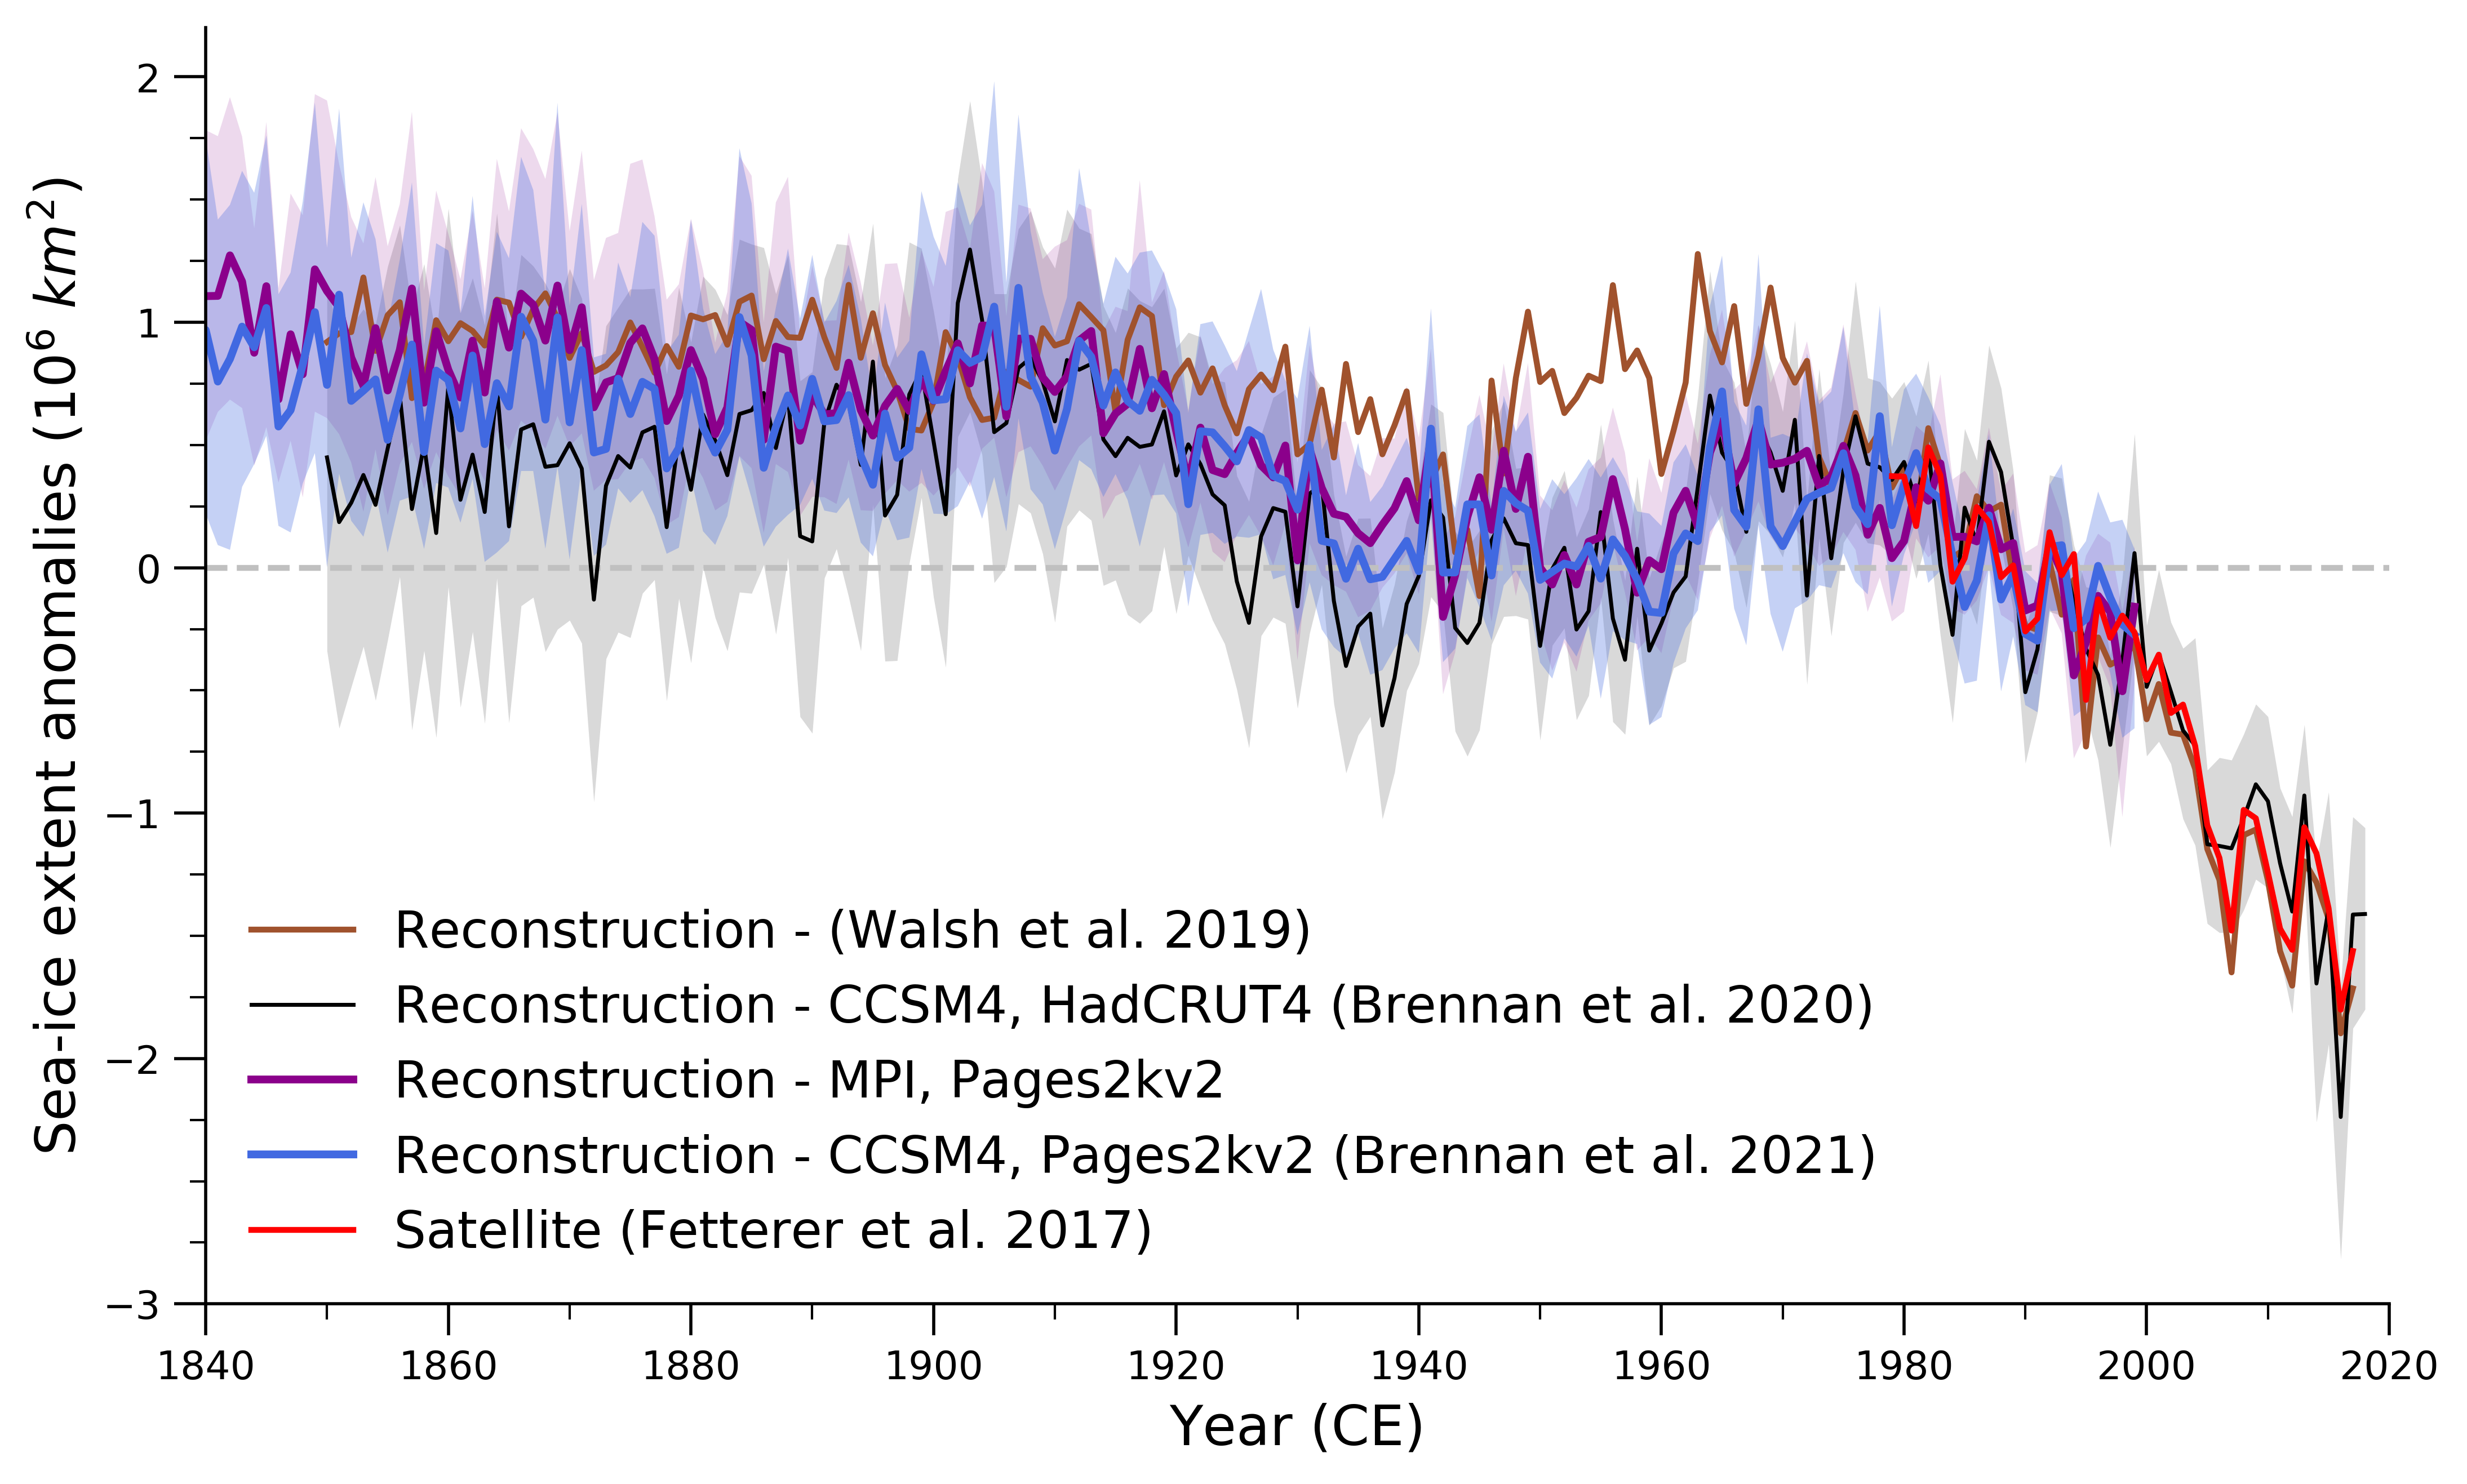

In [14]:
fig,ax = plt.subplots(1,figsize=(10,6))
plt.axhline(0,linestyle='--',color='silver')

plt.fill_between(bren2020_time,sie_CCSM4_HadCRUT4_2_5_anom,sie_CCSM4_HadCRUT4_97_5_anom,
                 color='k',alpha=0.15,linewidth=0.01)
plt.fill_between(recon_years,sie_mpi_2_5_anom,sie_mpi_97_5_anom,
                 alpha=0.15, color='darkmagenta',linewidth=0.0)
plt.fill_between(recon_years,sie_ccsm4_2_5_anom,sie_ccsm4_97_5_anom,
                 alpha=0.3, color='royalblue',linewidth=0.01)

plt.plot(walsh_time,walsh_sie_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))
plt.plot(bren2020_time,sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
         label='Reconstruction - CCSM4, HadCRUT4 (Brennan et al. 2020)',
         color='k',linewidth=1)
plt.plot(recon_years,sie_ensmn_anom_mpi,color='darkmagenta',#'#8756e4',
         label='Reconstruction - MPI, Pages2kv2',linewidth=2)
plt.plot(recon_years,sie_ensmn_anom_ccsm4,color='royalblue',#'#8756e4',
         label='Reconstruction - CCSM4, Pages2kv2 (Brennan et al. 2021)',linewidth=2)

plt.plot(fet_time,fet_sie_anom,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)

# plt.legend(fontsize=13,bbox_to_anchor=(0.79, 0.35),frameon=False)
plt.legend(fontsize=13,loc='lower left',frameon=False)
ce_corr_plt_ccsm4 = (('(Brennan et al. 2020, DA proxy recon): R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_ccsm4**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_ccsm4))
ce_corr_plt_sat = (('(Satellite, DA proxy recon):                   R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_sat**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_sat))


plt.xlim(1840,2020)
plt.ylim(-3,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sie_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
#plt.savefig(savedir+savename)

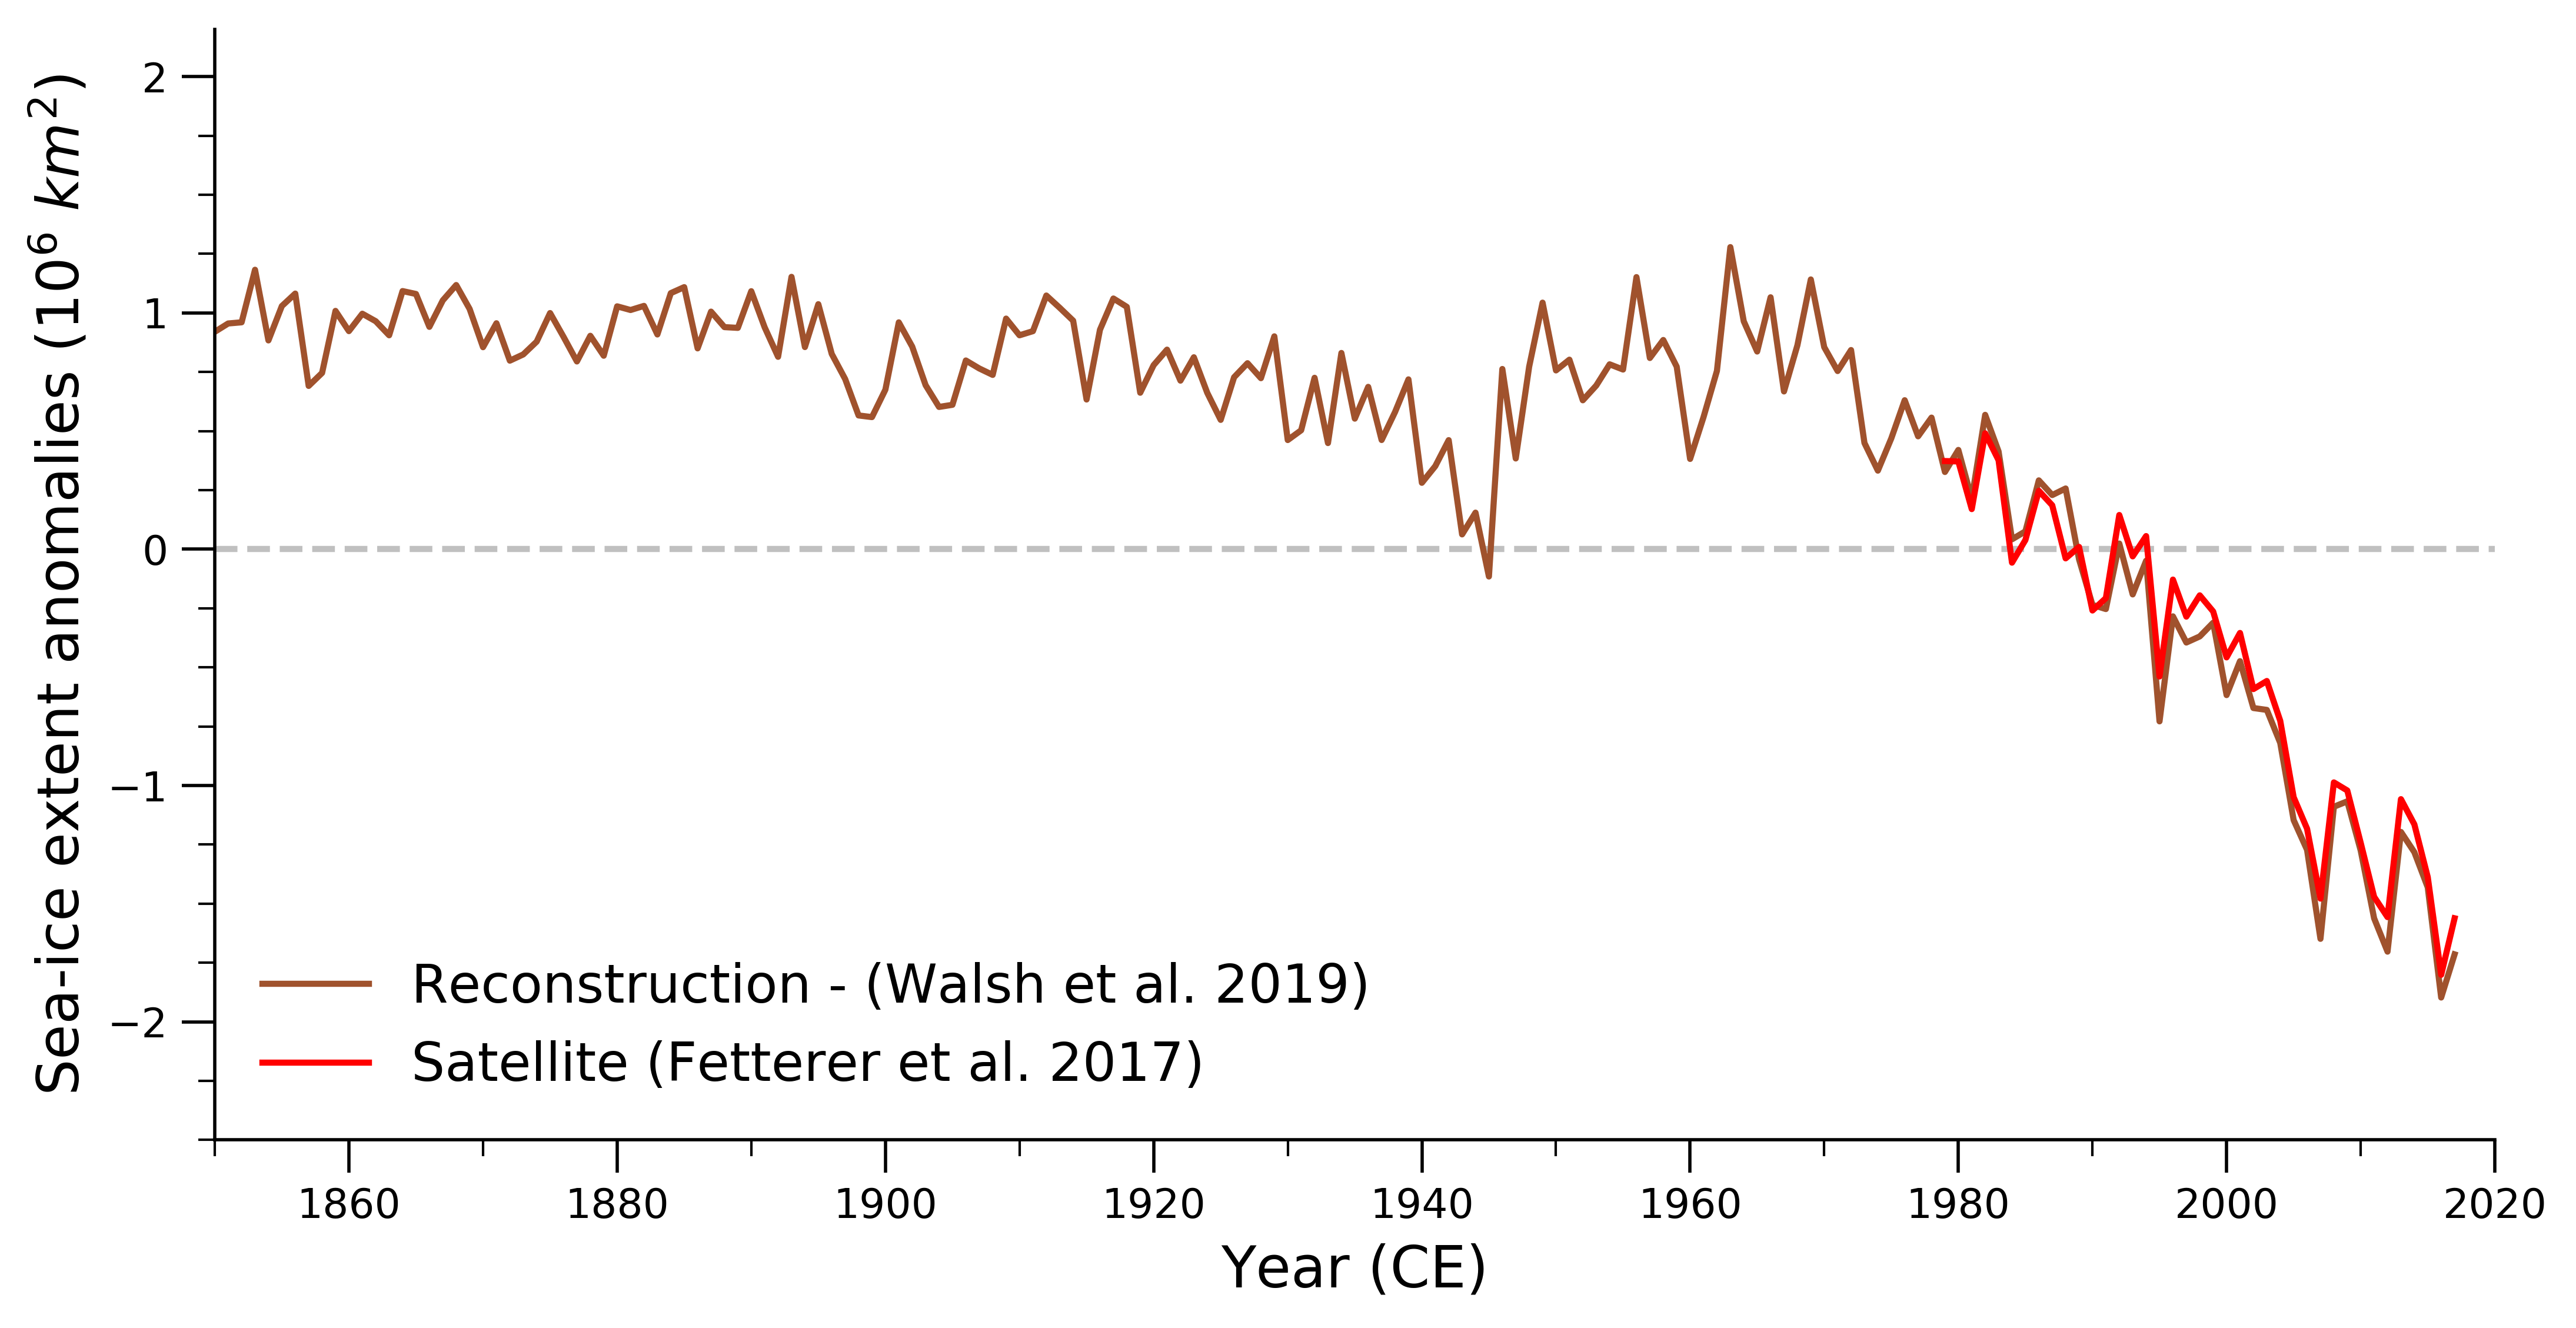

In [18]:
fig,ax = plt.subplots(1,figsize=(10,5))
plt.axhline(0,linestyle='--',color='silver')

# plt.fill_between(recon_years,sie_mpi_2_5_anom,sie_mpi_97_5_anom,
#                  alpha=0.15, color='darkmagenta',linewidth=0.0)
# plt.fill_between(recon_years,sie_ccsm4_2_5_anom,sie_ccsm4_97_5_anom,
#                  alpha=0.15, color='k',linewidth=0.01)
# plt.fill_between(bren2020_time,sie_MPI_HadCRUT4_2_5_anom,sie_MPI_HadCRUT4_97_5_anom,
#                  color='royalblue',alpha=0.3,linewidth=0.01)

plt.plot(walsh_time,walsh_sie_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))
# plt.plot(recon_years,sie_ensmn_anom_ccsm4,color='k',#'#8756e4',
#          label='Reconstruction - CCSM4, Pages2kv2 (Brennan et al. 2021)',linewidth=1)
# # plt.plot(bren2020_time,sie_bren2020['sie_CCSM4_HadCRUT4_anom'],
# #          label='Reconstruction - CCSM4, HadCRUT4 (Brennan et al. 2020)',
# #          color='royalblue',linewidth=2)
# plt.plot(bren2020_time,sie_bren2020['sie_MPI_HadCRUT4_anom'],
#          label='Reconstruction - MPI, HadCRUT4 (Brennan et al. 2020)',
#          color='royalblue',linewidth=2)
# plt.plot(recon_years,sie_ensmn_anom_mpi,color='darkmagenta',#'#8756e4',
#          label='Reconstruction - MPI, Pages2kv2',linewidth=2)

plt.plot(fet_time,fet_sie_anom,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)

# plt.legend(fontsize=13,bbox_to_anchor=(0.79, 0.35),frameon=False)
plt.legend(fontsize=13,loc='lower left',frameon=False)
ce_corr_plt_ccsm4 = (('(Brennan et al. 2020, DA proxy recon): R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_ccsm4**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_ccsm4))
ce_corr_plt_sat = (('(Satellite, DA proxy recon):                   R$^{2}$ = ' + '{:,.2f}'.format(corr_sie_ccsm4_sat**2))+
               ', CE = '+'{:,.2f}'.format(ce_sie_ccsm4_sat))


plt.xlim(1850,2020)
plt.ylim(-2.5,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sie_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
#plt.savefig(savedir+savename)

## SIA Comparison: Figure S4

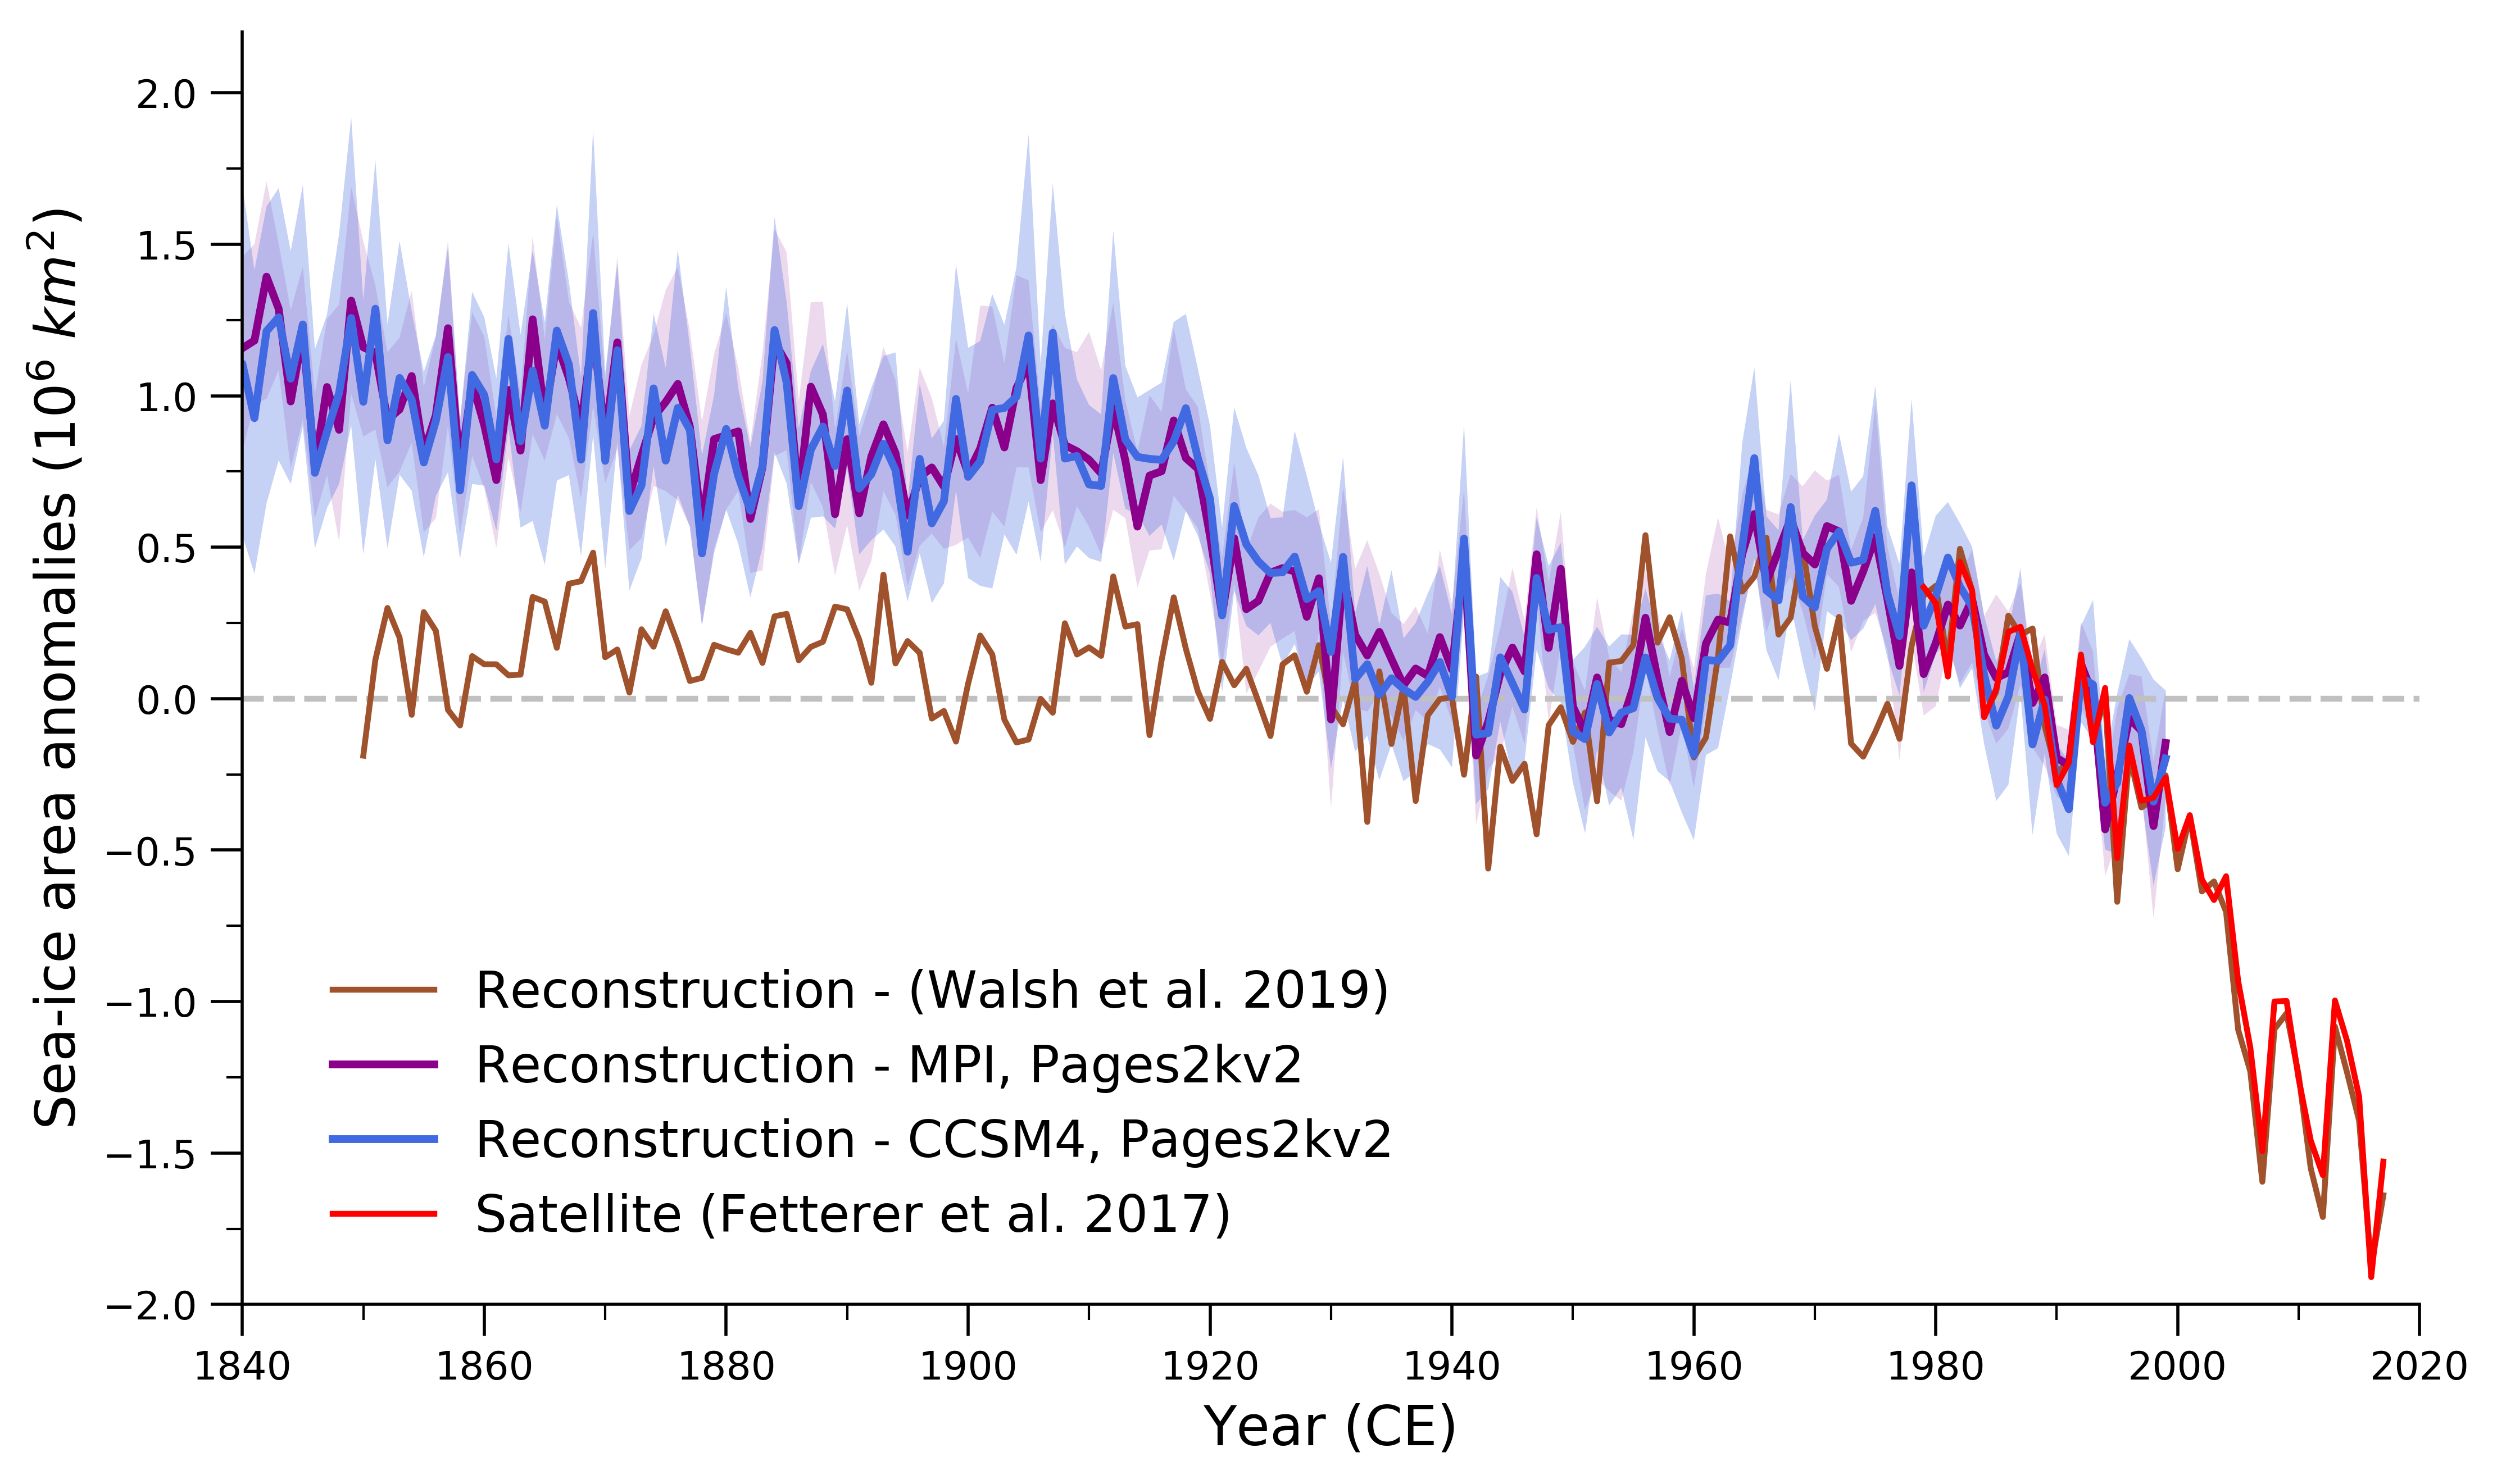

In [17]:
fig,ax = plt.subplots(1,figsize=(10,6))
plt.axhline(0,linestyle='--',color='silver')

plt.fill_between(recon_years,sia_mpi_2_5_anom,sia_mpi_97_5_anom,
                 alpha=0.15, color='darkmagenta',linewidth=0.0)
plt.fill_between(recon_years,sia_ccsm4_2_5_anom,sia_ccsm4_97_5_anom,
                 alpha=0.3, color='royalblue',linewidth=0.01)

plt.plot(walsh_time,walsh_sia_anom,
         label='Reconstruction - (Walsh et al. 2019)', color='sienna',#'#a2653e',#'saddlebrown',#color='#836539',
         linewidth=1.5)#, linestyle=(0,(1,1))

plt.plot(recon_years,sia_ensmn_anom_mpi,color='darkmagenta',#'#8756e4',
         label='Reconstruction - MPI, Pages2kv2',linewidth=2)
plt.plot(recon_years,sia_ensmn_anom_ccsm4,color='royalblue',#'#8756e4',
         label='Reconstruction - CCSM4, Pages2kv2',linewidth=2)

plt.plot(fet_time,fet_sia_anom_adj,label='Satellite (Fetterer et al. 2017)', color='r',linewidth=1.5)

plt.ylabel('Sea-ice area anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)

plt.legend(fontsize=13,bbox_to_anchor=(0.55, 0.3),frameon=False)

plt.xlim(1840,2020)
plt.ylim(-2.0,2.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'tot_sia_ccsm4_mpi_v_sat_walshv2_brennan_ccsm4_10it_1850_2017.png'
plt.savefig(savedir+savename)

In [18]:
[ce_sia_recon_mpi_ccsm4,
 corr_sia_recon_mpi_ccsm4,_,_] = find_ce_corr(sia_ensmn_anom_ccsm4, 
                                              sia_ensmn_anom_mpi,
                                              recon_years,
                                              recon_years,1850,1999)

[ce_sia_walsh_mpi,corr_sia_walsh_mpi,
 var_sia_sat_walsh_mpi,
 var_sia_recon_walsh_mpi] = find_ce_corr(sia_ensmn_anom_mpi, 
                                          walsh_sia_anom,
                                          walsh_time,
                                          recon_years,1850,1999)

[ce_sia_walsh_ccsm4,corr_sia_walsh_ccsm4,
 var_sia_sat_walsh_ccsm4,
 var_sia_recon_walsh_ccsm4] = find_ce_corr(sia_ensmn_anom_ccsm4, 
                                           walsh_sia_anom,
                                           walsh_time,
                                           recon_years,1850,1999)

In [19]:
[ce_sia_ccsm4_sat,corr_sia_ccsm4_sat,
 var_sia_sat_ccsm4_sat,
 var_sia_recon_ccsm4_sat] = find_ce_corr(sia_ensmn_anom_ccsm4, 
                                         fet_sia_anom_adj,fet_time,
                                         recon_years,anom_start,anom_end-1)

[ce_sia_mpi_sat,corr_sia_mpi_sat,
 var_sia_sat_ccsm4_sat,
 var_sia_recon_ccsm4_sat] = find_ce_corr(sia_ensmn_anom_mpi, 
                                         fet_sia_anom,fet_time,
                                         recon_years,anom_start,anom_end-1)

In [20]:
# Revision 1 reconstructions: 
print("R^2:   Walsh v CCSM4   = "+ str(np.round(corr_sia_walsh_ccsm4**2,2)))
print("R^2:   Walsh v MPI     = "+ str(np.round(corr_sia_walsh_mpi**2,2))+'\n')

print("CE:    Walsh v CCSM4   = "+ str(np.round(ce_sia_walsh_ccsm4,2)))
print("CE:    Walsh v MPI     = "+ str(np.round(ce_sia_walsh_mpi,3))+'\n')

print("R^2:   sat v CCSM4     = "+ str(np.round(corr_sia_ccsm4_sat**2,2)))
print("R^2:   sat v MPI       = "+ str(np.round(corr_sia_mpi_sat**2,2))+'\n')

print("CE:    sat v CCSM4     = "+ str(np.round(ce_sia_ccsm4_sat,2)))
print("CE:    sat v MPI       = "+ str(np.round(ce_sia_mpi_sat,2))+'\n')

print("R^2:   Recon MPI v CCSM4 = "+ str(np.round(corr_sia_recon_mpi_ccsm4**2,2)))
print("CE:    Recon MPI v CCSM4 = "+ str(np.round(ce_sia_recon_mpi_ccsm4,2)))

R^2:   Walsh v CCSM4   = 0.16
R^2:   Walsh v MPI     = 0.16

CE:    Walsh v CCSM4   = -6.02
CE:    Walsh v MPI     = -5.883

R^2:   sat v CCSM4     = 0.57
R^2:   sat v MPI       = 0.12

CE:    sat v CCSM4     = 0.53
CE:    sat v MPI       = -0.99

R^2:   Recon MPI v CCSM4 = 0.94
CE:    Recon MPI v CCSM4 = 0.94
